In [1]:
# Imports
library(Seurat)
library(SingleCellExperiment)
library(SingleR)
library(celldex)    
library(ggplot2)
library(clustree)
library(gridExtra)

Warning message:
"package 'Seurat' was built under R version 4.4.2"
Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.4.2"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.2"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.4.2"

Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, 

In [ ]:
# Set wd
setwd("../../../Data/Cochaine et al. (2018)")
list.files()
getwd()

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=15, repr.plot.height=12)

# Read in data
HFD_20weeks <- Read10X(data.dir = "Cochain_2018_20weeks_HFD")
HFD_11weeks <- Read10X(data.dir = "Cochain_2018_11weeks_HFD")
healthy <- Read10X(data.dir = "Cochain_2018_healthy_aorta")

# Create Seurat objects
HFD_20weeks_obj <- CreateSeuratObject(HFD_20weeks, project="HFD 20")
HFD_11weeks_obj <- CreateSeuratObject(HFD_11weeks, project="HFD 11")
healthy_obj <- CreateSeuratObject(healthy, project="Healthy")

# Merge the Seurat objects
sc.data <- merge(HFD_20weeks_obj, y=list(HFD_11weeks_obj, healthy_obj),
                    add.cell.ids = c("HFD 20", "HFD 11", "Healthy"),
                    project="Merged version of HFD20, HFD11 and healthy")

# Merge layers
sc.data[["RNA"]] <- JoinLayers(sc.data[["RNA"]])


# Export R object for all mice integration
sc.data[["Species"]] <- "Mouse"
saveRDS(sc.data, file = "Cochaine_raw.rds")

[1] "clustree_combined_visible.pdf"  "Cochain_2018_11weeks_HFD"      
[3] "Cochain_2018_20weeks_HFD"       "Cochain_2018_healthy_aorta"    
[5] "Cochaine_raw.rds"               "Cochaine_raw_modified_orig.rds"

[1] "c:/Users/phili/Desktop/BMW Jaar 3/Afstudeerscriptie/project_scriptie/Data/Cochaine et al. (2018)"

In [3]:
# Export R object for all mice integration
# We need to change orig.ident due to sample sizes
# Create Seurat obj
WD20_obj2 <- CreateSeuratObject(HFD_20weeks, project="HFD/ WD 20") # WD 20 weken
CD20_obj2 <- CreateSeuratObject(HFD_11weeks, project="HFD 10/11") # Chow 20 weken
CD8_obj2 <- CreateSeuratObject(healthy, project="Healthy (CD20, CD8, CHOW)") # Chow 8 weken

# Merge the Seurat objects
sc.data2 <- merge(WD20_obj2, y=list(CD20_obj2, CD8_obj2),
                    add.cell.ids = c("HFD/ WD 20", "HFD 10/11", "Healthy (CD20, CD8, CHOW)"))

sc.data2[["Species"]] <- "Mouse"
saveRDS(sc.data2, file = "Cochaine_raw_modified_orig.rds")

In [4]:
# Preprocessing function which performs a basic workflow for scRNA seq analysis
pre_process <- function(data, nFeatures_RNA = 200, nCounts_RNA = 3, percents.mt = 5, pattern = "MT", resolutions = seq(0.5, 1.5, by = 0.1), k.weights = 100) {
    # Split
    data[["RNA"]] <- split(data[["RNA"]], f = data$orig.ident)

    # Get percentage mt                      
    data[["percent.mt"]] <- PercentageFeatureSet(data, pattern = sprintf("^%s-", pattern))

    # Subsets
    data <- subset(x = data, subset = nFeature_RNA >= nFeatures_RNA & nCount_RNA >= nCounts_RNA & percent.mt <= percents.mt)

    # Normalization
    data <- NormalizeData(data, normalization.method = "LogNormalize", scale.factor = 10000)
    
    # Find Variable features
    data <- FindVariableFeatures(data, selection.method = "vst", nfeatures = 2000)
    
    # Scale Data
    data <- ScaleData(data, vars.to.regress = c("percent.mt", "nFeature_RNA"))
    
    # Run PCA
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Run UMAP
    data <- RunUMAP(data, reduction = "pca", dims = 1:significant_pcs, verbose=FALSE)

    # Integrate
    data <- IntegrateLayers(object = data, method = CCAIntegration, orig.reduction = "pca", new.reduction = "integrated.cca", k.weight = k.weights,verbose = FALSE)

    data[["RNA"]] <- JoinLayers(data[["RNA"]])

    # Post integration processing
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Clustering
    data <- FindNeighbors(data, reduction = "integrated.cca", dims = 1:significant_pcs)
    data <- FindClusters(data, resolution = resolutions)
    data <- RunUMAP(data, dims = 1:significant_pcs, reduction = "integrated.cca", verbose=FALSE)

    return(data)
}

data <- pre_process(sc.data, pattern= "mt")

Normalizing layer: counts.HFD_20

Normalizing layer: counts.HFD_11

Normalizing layer: counts.Healthy

Finding variable features for layer counts.HFD_20

Finding variable features for layer counts.HFD_11

Finding variable features for layer counts.Healthy

Regressing out percent.mt, nFeature_RNA

Centering and scaling data matrix

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2444
Number of edges: 88842

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9109
Number of communities: 14
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2444
Number of edges: 88842

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9002
Number of communities: 15
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2444
Number of edges: 88842

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8898
Number of communities: 16
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2444
Number of edges: 88842

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8798
Number of communities: 16
Elapsed time: 0 seconds
Modularity Optimizer

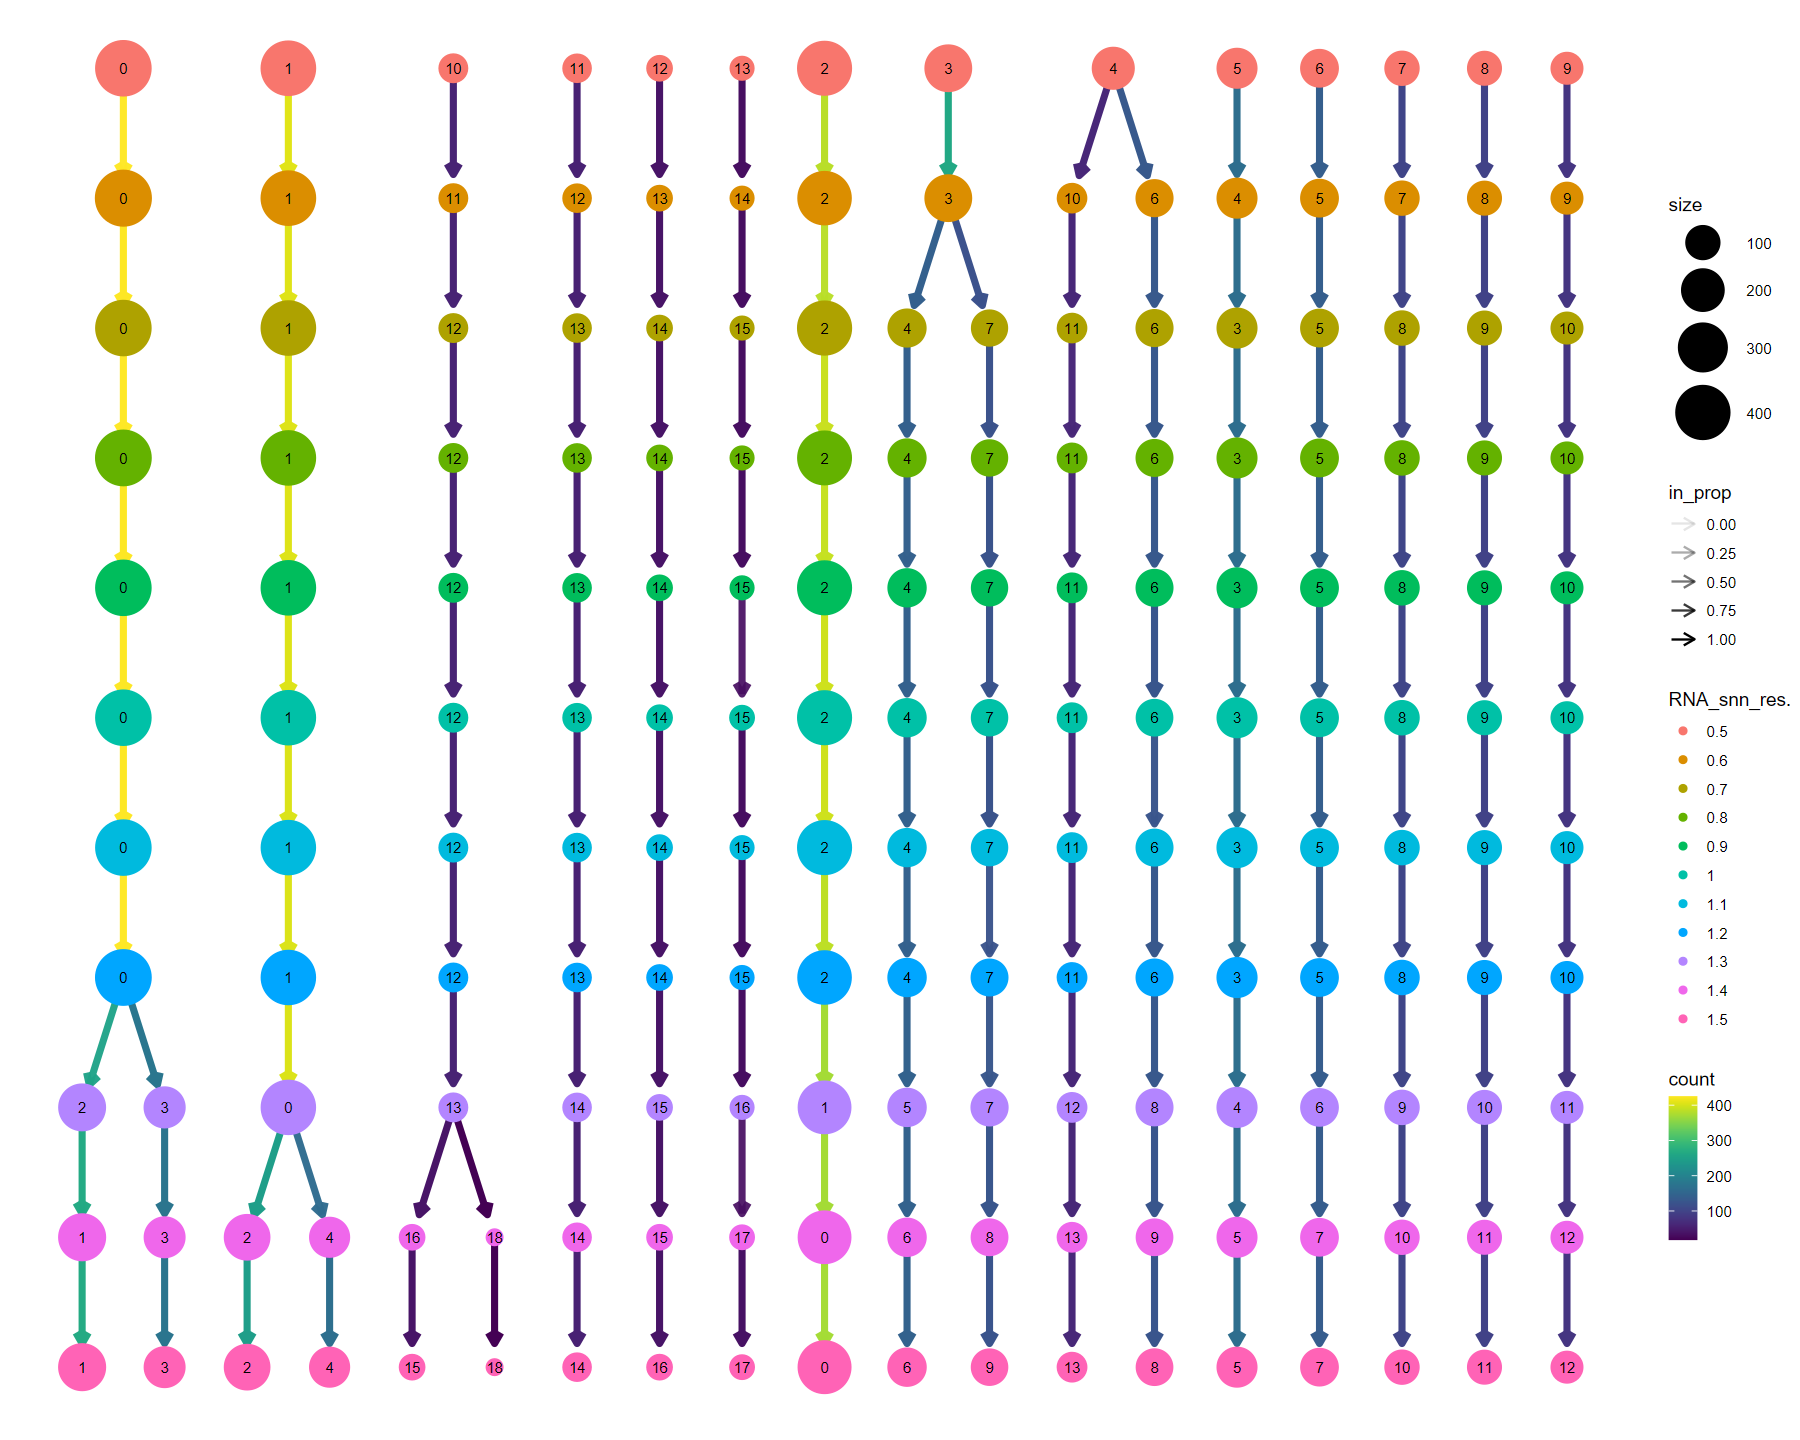

In [5]:
# This cell is meant to analyze the different resolutions and see which one is the best
clustree(data, prefix= "RNA_snn_res.", layout = "sugiyama")

In [6]:
# Assign the slot "Seurat Cluster" to the desired resolution
data$seurat_clusters <- data$`RNA_snn_res.1.1`

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
B cells,0,1,0,0,0,124,0,0,0,0,1,0,0,0,0,1
Dendritic cells,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,4
Erythrocytes,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Fibroblasts,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Granulocytes,0,0,0,0,1,0,0,0,0,0,0,0,50,0,0,0
Macrophages,417,0,330,0,24,2,1,120,2,25,0,24,5,0,3,7
Monocytes,7,1,63,1,118,1,125,2,0,21,1,39,0,0,36,18
NK cells,0,37,1,2,0,0,0,0,0,3,12,0,1,53,0,0
T cells,0,361,1,161,0,0,0,0,100,49,66,0,0,2,0,1


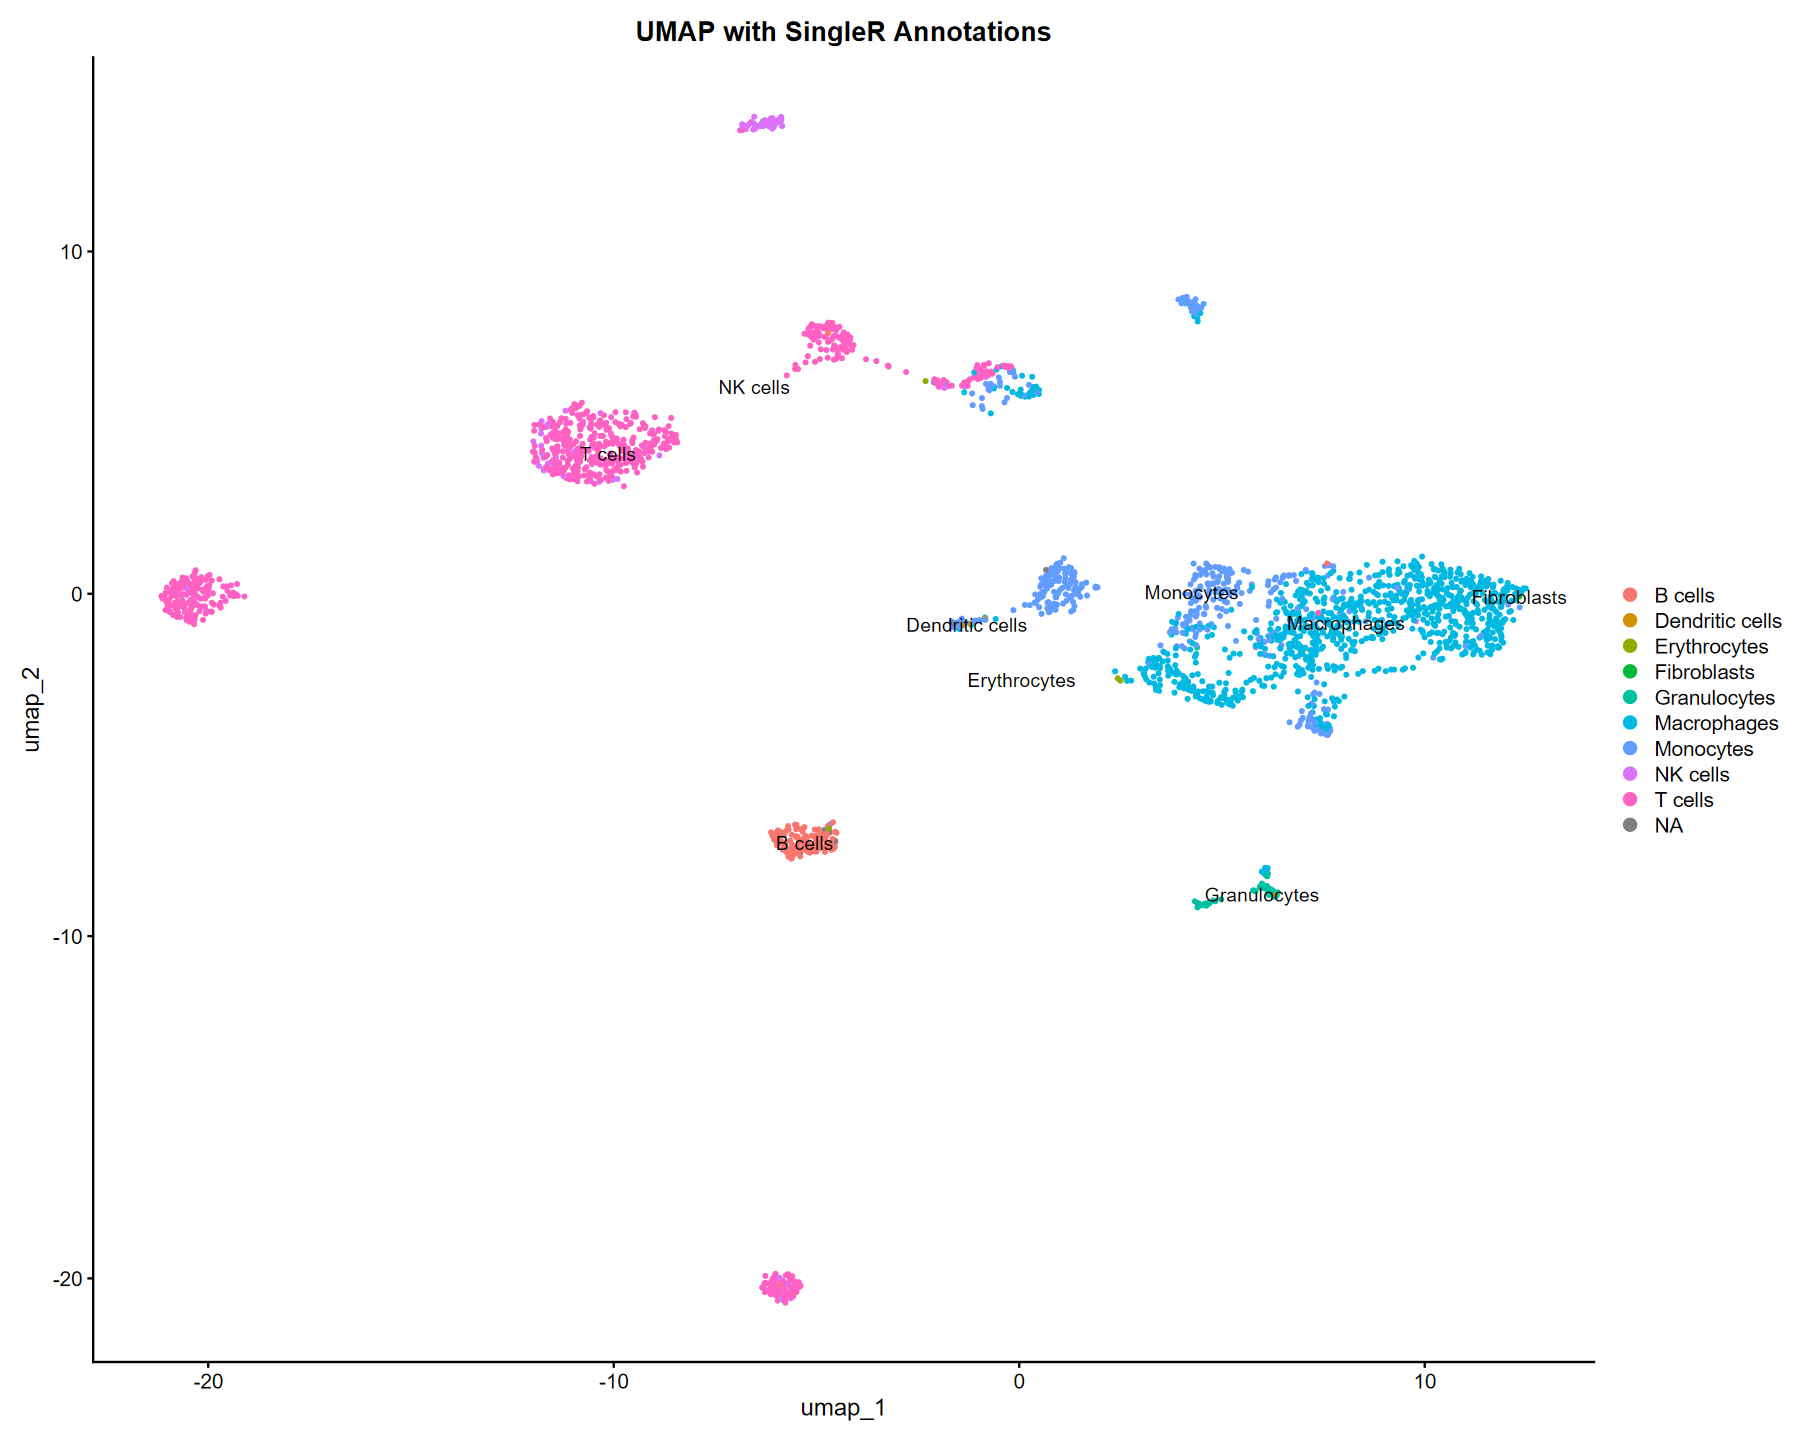

In [7]:
# Annotation
# Get reference atlas from CellDex
MouseRNAseqData <- celldex::MouseRNAseqData()

# Convert to SCE to use SingleR
data.sce <- as.SingleCellExperiment(data)

# Predict cell types
pred.MouseRNAseqData <- SingleR(test = data.sce, ref = MouseRNAseqData, assay.type.test=1,
    labels = MouseRNAseqData$label.main)

# View annotations
cluster_table <- cbind(table(pred.MouseRNAseqData$pruned.labels,data.sce$seurat_clusters))
cluster_table

# Add SingleR predicted labels to Seurat metadata
data$SingleR_Labels <- pred.MouseRNAseqData$pruned.labels

# UMAP plot with SingleR labels
DimPlot(data, reduction = "umap", group.by = "SingleR_Labels", label = TRUE) + 
    ggtitle("UMAP with SingleR Annotations")

In [9]:
# Function to get the a specific cell type
get_macrophages <- function(data, table, cell_type = "Macrophages") {
    # Find clusters where atleast > 15% is classified as macrophages
    clusters <- which(t(cluster_table[cell_type, ] / colSums(cluster_table) * 100) > 5) - 1
    
    # Get subsets by first filtering on macrophage dominant clusters
    data <- subset(data, subset = seurat_clusters %in% clusters)

    # And then only select the macrophages
    data <- subset(data, subset = SingleR_Labels == cell_type)

    return(data)
}

macrophages <- get_macrophages(data, cluster_table, cell_type = "Macrophages")

Warning message:
"Removing 1 cells missing data for vars requested"


In [10]:
# Reprocess the subset
# To reintegrate, there needs to be a new Seurat Object created
macrophage_data <- CreateSeuratObject(counts = macrophages@assays$RNA$counts)
macrophage_data <- pre_process(macrophage_data, resolutions = seq(0.1, 1, by=0.1), k.weights = 57)

Normalizing layer: counts.HFD_20

Normalizing layer: counts.HFD_11

Normalizing layer: counts.Healthy

Finding variable features for layer counts.HFD_20

Finding variable features for layer counts.HFD_11

Finding variable features for layer counts.Healthy

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -1.5051"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.30103"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.0863e-14"
Regressing out percent.mt, nFeature_RNA

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 955
Number of edges: 35513

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9055
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 955
Number of edges: 35513

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8473
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 955
Number of edges: 35513

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8128
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 955
Number of edges: 35513

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7796
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version

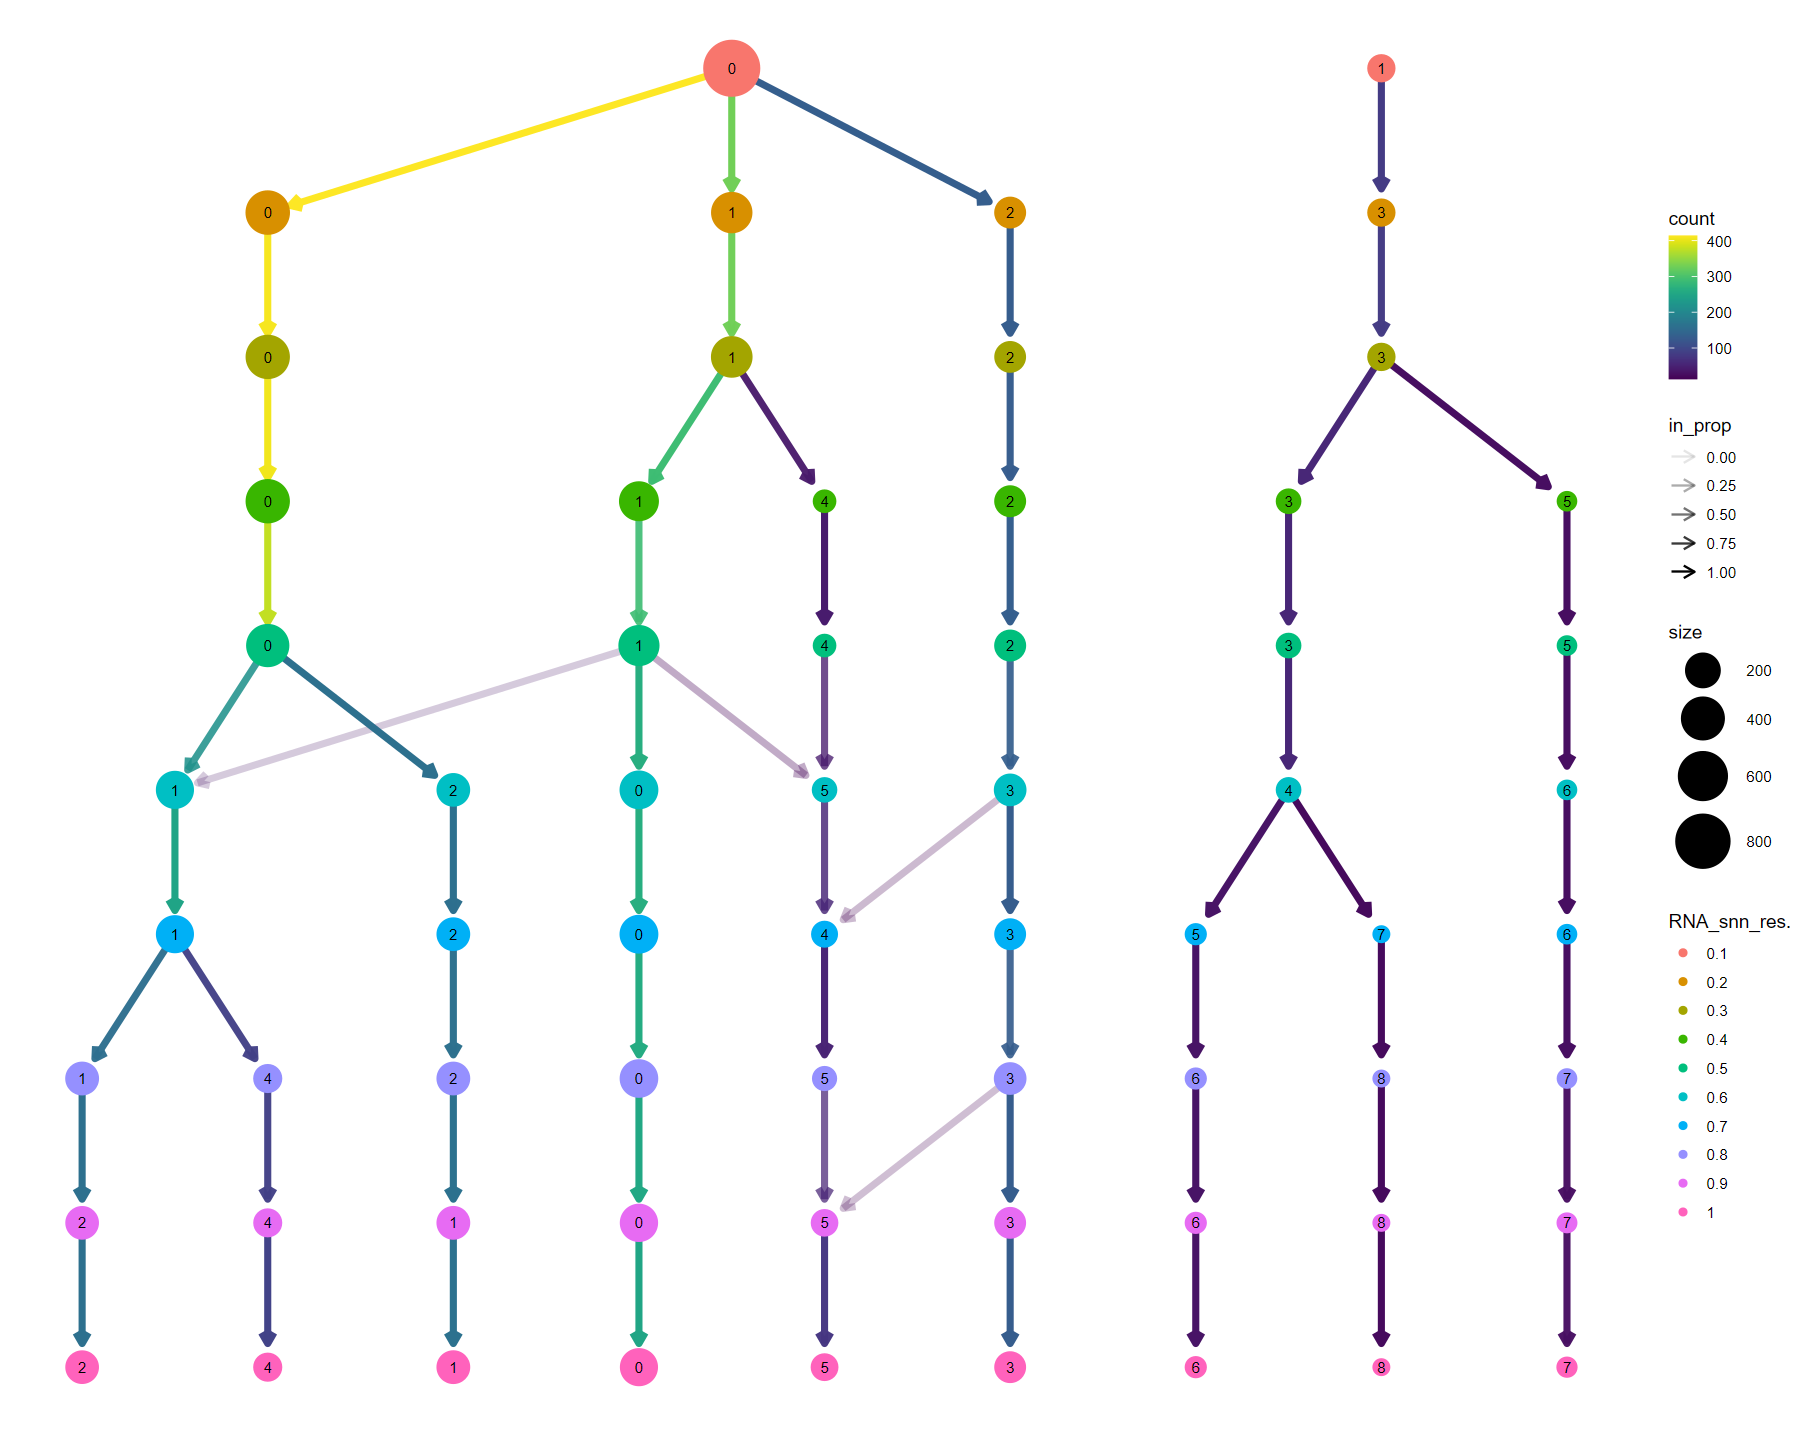

In [11]:
# View the clustree again for the best resolution
clustree(macrophage_data, prefix= "RNA_snn_res.", layout = "sugiyama")

In [1]:
# Assign the slot "Seurat Cluster" to the desired resolution
macrophage_data$seurat_clusters <- macrophage_data$`RNA_snn_res.0.4`
Idents(macrophage_data) <- "seurat_clusters"

# Plot
DimPlot(macrophage_data, reduction = "umap", group.by = "RNA_snn_res.0.4", label = TRUE) + 
    ggtitle("Macrophages subset integrated")

ERROR: Error: object 'macrophage_data' not found


In [13]:
# Some marker genes according to Winther & Willemsen
features_inflammatory <- c("S100a8", "S100a9", "Il1b", "Casp1", "Casp4", "Nlrp3", "Tnf", "Egr1", "Zpf36", "Ier3", "Cepbp", "Cxcl2", "Ccl2-5")
features_resident <- c("Lyve1", "Cx3cr1", "Folr2", "C1qa", "C1qb", "C1qc", "Cd74", "Hla-dra", "Hla-drb1", "Pf4", "Sepp1", "Vsig4", "F13a1")
features_trem2 <- c("Trem2", "Cd9", "Fabp5", "Apoe", "Apoc1", "Spp1", "Lgals3", "Ctsb")
features_ifnic <- c("Isg15", "Irf7", "Ifit3", "Ifit1")
features_proliferating <- c("Stmn1", "Top2a", "Mki67", "Tuba1b", "Tubb5")

# Add a module score to the Seurat object
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_inflammatory), name = "FeatureGeneScore_inflammatory")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_resident), name = "FeatureGeneScore_resident_like")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_trem2), name = "FeatureGeneScore_trem2")

# Vln plots
inflammatory_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_inflammatory1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for inflammatory macrophage markers")
residents_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_resident_like1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for resident-like macrophage markers")
trem2_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_trem21", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for trem2 foamy macrophage markers")

# Visualizing DotPlots to view marker genes
inflammatory_dot <- DotPlot(macrophage_data, features = features_inflammatory) + 
  ggtitle("Inflammatory Macrophages") + RotatedAxis()

resident_dot <- DotPlot(macrophage_data, features = features_resident) + 
  ggtitle("Resident-Like Macrophages")

TREM2_dot <- DotPlot(macrophage_data, features = features_trem2) + 
  ggtitle("TREM2 'Foamy' Macrophages")

IFNIC_dot <- DotPlot(macrophage_data, features = features_ifnic) + 
  ggtitle("IFNIC Macrophages")

proliferating_dot <- DotPlot(macrophage_data, features = features_proliferating) + 
  ggtitle("Proliferating Macrophages")


Warning message:
"The following features are not present in the object: Zpf36, Cepbp, Ccl2-5, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: Hla-dra, Hla-drb1, not searching for symbol synonyms"
Warning message:
"The following requested variables were not found: Zpf36, Cepbp, Ccl2-5"
Warning message:
"The following requested variables were not found: Hla-dra, Hla-drb1"


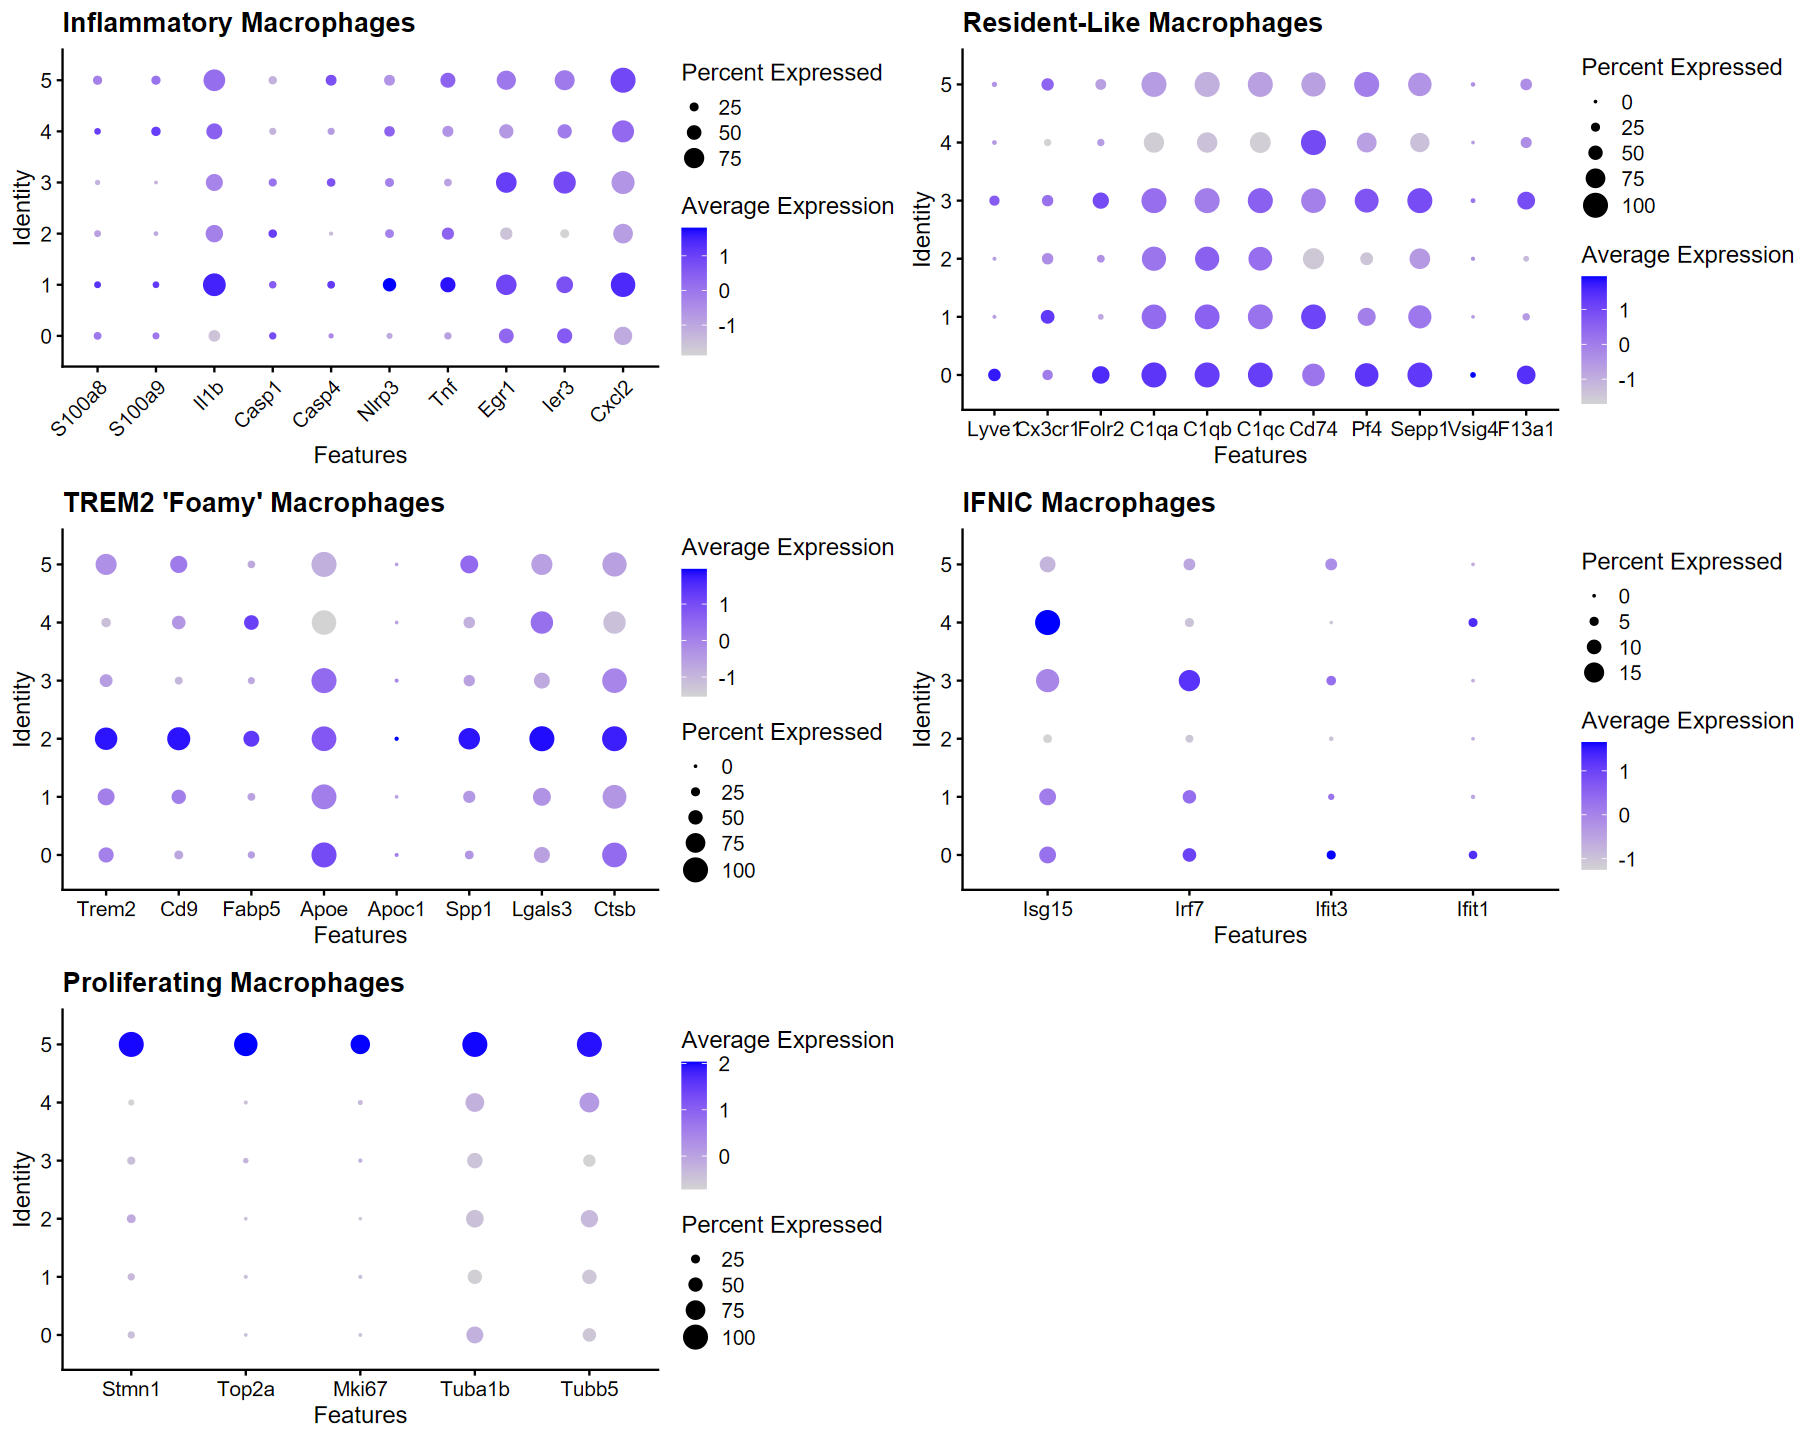

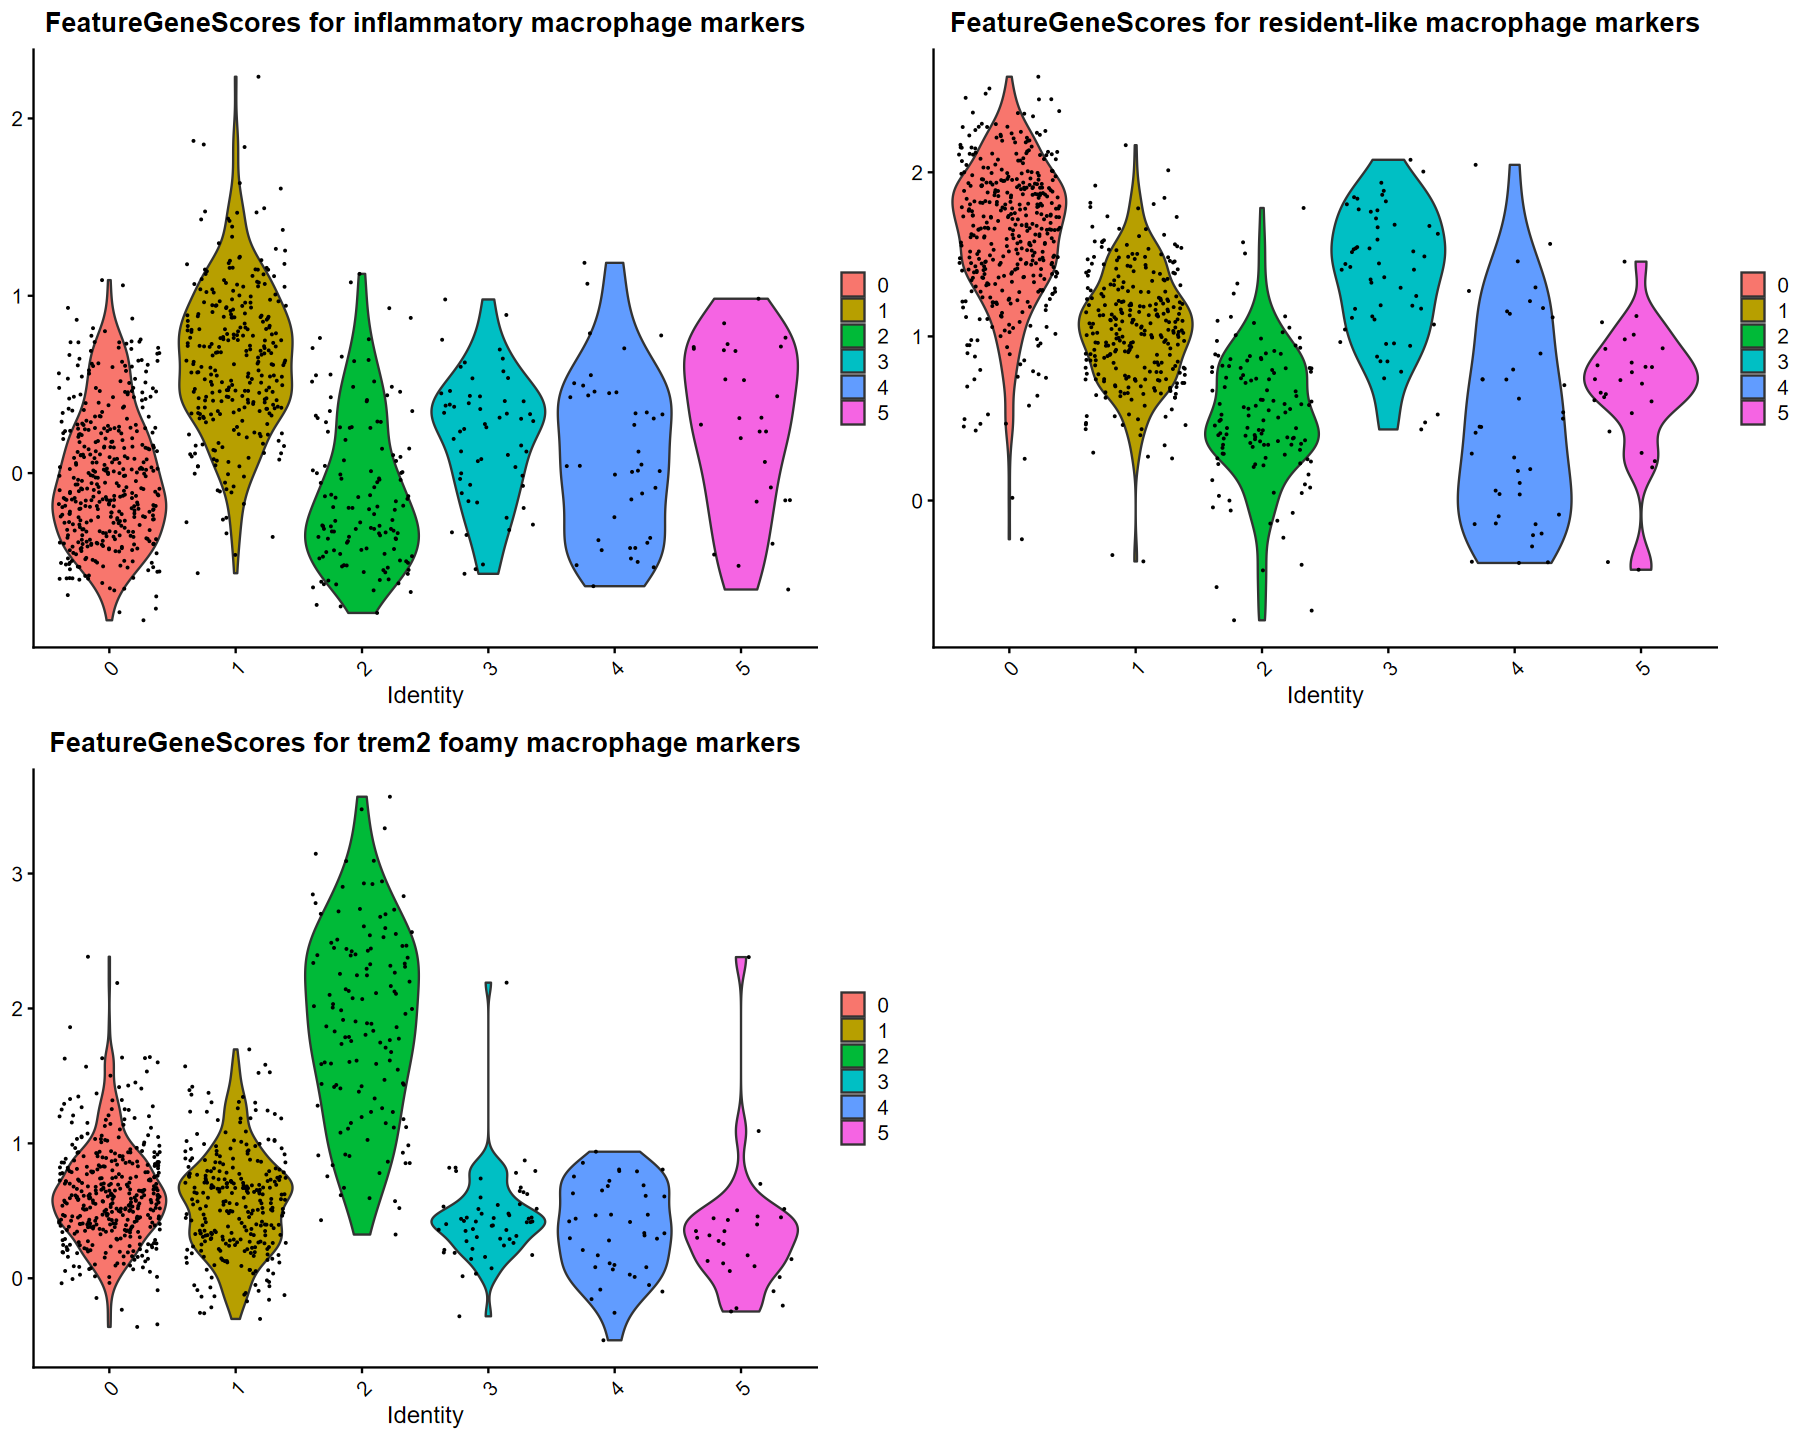

In [ ]:
# Plot
grid.arrange(inflammatory_dot, resident_dot, TREM2_dot, IFNIC_dot, proliferating_dot, ncol = 2)
grid.arrange(inflammatory_vln, residents_vln, trem2_vln, ncol=2)

In [ ]:
# Assign new labels
macrophage_data <- RenameIdents(macrophage_data,
                                   '0' = 'Resident-like Macrophages',
                                   '1' = 'Inflammatory Macrophages',
                                   '2' = 'TREM2 Foamy Macrophages', 
                                   '3' = 'Inflammatory Macrophages')

# Proportion tables
annotations_per_origin <- table(Idents(macrophage_data), macrophage_data$orig.ident)
annotations_per_origin_prop <- prop.table(table(Idents(macrophage_data), macrophage_data$orig.ident), margin = 2) * 100

# Subtype plots after annotation
subtype_annotated_plot <- DimPlot(macrophage_data, reduction = "umap", label = TRUE)
subtype_origin_plot <- DimPlot(macrophage_data, reduction = "umap", group.by = "orig.ident", label = TRUE)

# Combine tables side by side
combined_df <- cbind(annotations_per_origin, annotations_per_origin_prop)

,Healthy,HFD 11,HFD 20,Healthy,HFD 11,HFD 20
Resident-like Macrophages,42,111,256,65.625,37.755102,42.881072
Inflammatory Macrophages,12,106,229,18.750,36.054422,38.358459
TREM2 Foamy Macrophages,2,56,73,3.125,19.047619,12.227806
4,4,14,23,6.250,4.761905,3.852596
5,4,7,16,6.250,2.380952,2.680067


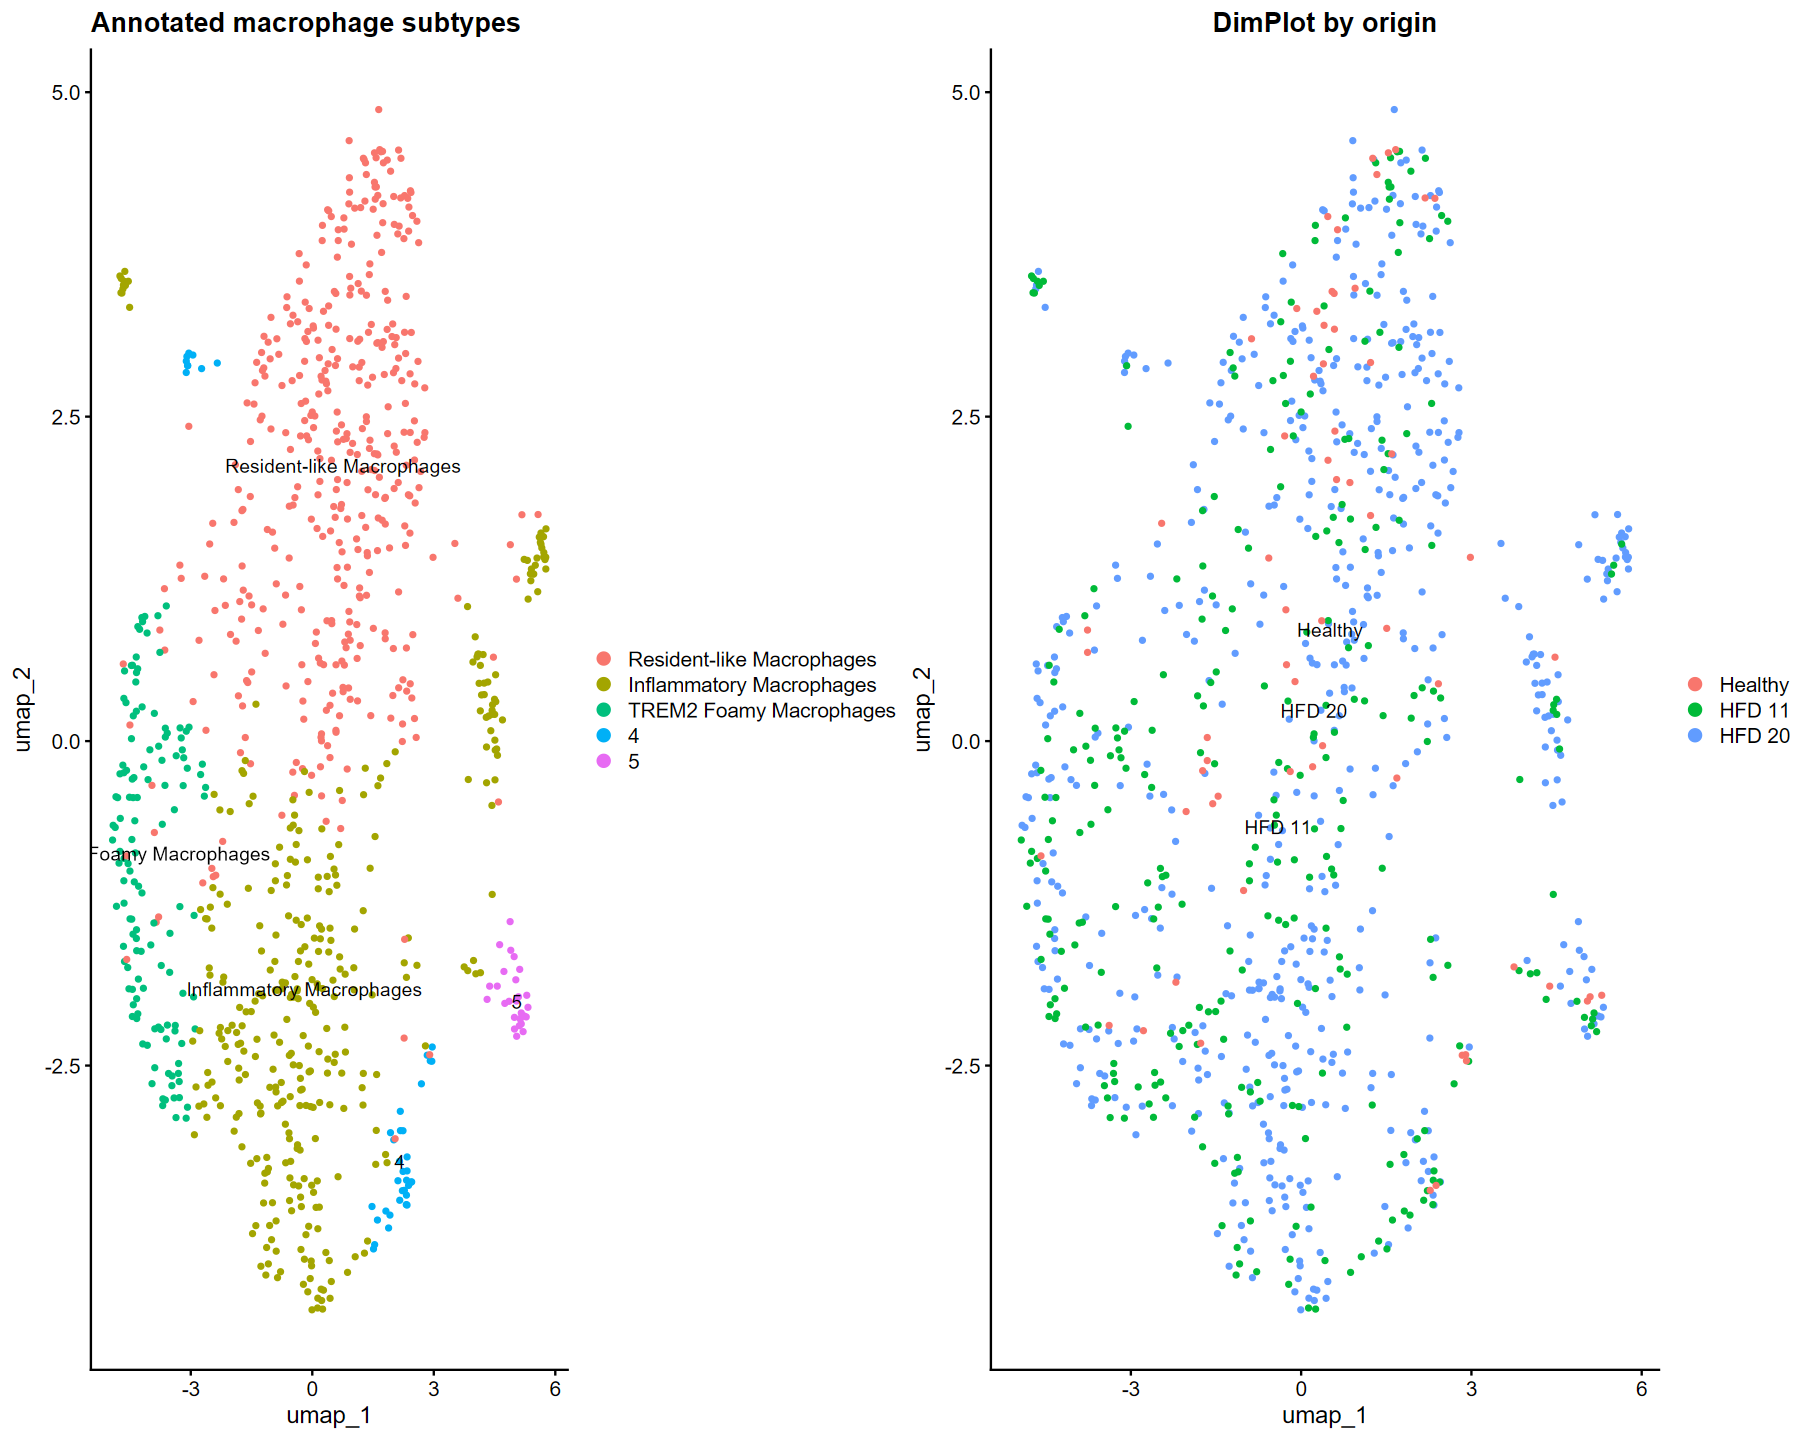

In [16]:
# Plot table
combined_df

# Plotting annotations and titles
grid.arrange(
    subtype_annotated_plot + ggtitle("Annotated macrophage subtypes"),
    subtype_origin_plot + ggtitle("DimPlot by origin"),
    ncol=2
)

In [17]:
# Save final object
saveRDS(macrophage_data, file = "Cochaine_macrophages_annotated.rds")